# Getting Started: Importing dependencies and data

In [3]:
# Dependencies
import pandas as pd
import os
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Imports method used for connecting to DBs
from sqlalchemy import create_engine

# Import method for reflecting tables into classes.
from sqlalchemy.ext.automap import automap_base

# Imports method for temporarily binding to DBs
from sqlalchemy.orm import Session

In [4]:
# Use SQLAlchemy create_engine to connect to your sqlite database.
engine = create_engine('sqlite:///hawaii.sqlite')

# Use SQLAlchemy automap_base() to reflect your tables into classes.
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# Print all of the classes mapped to the Base
Base.classes.keys()

['measurements', 'stations']

In [5]:
# Save references to the Station and Measurement classes.
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [6]:
# Create a session
session = Session(engine)

# Precipitation Analysis

In [7]:
# Design a query to retrieve the last 12 months of precipitation data.
begin_date = date.today() - timedelta(days=365)

precip_12mo_query = session.query(Measurement).filter(Measurement.date>=begin_date)

In [8]:
# Select only the date and prcp values.
# Load the query results into a Pandas DataFrame and 
# set the index to the date column.

# Initiating an empty list to hold precip data.
precip_meas = []
precip_dates = []

# Looping through each of the records from the past
# year and appending data to lists.
for record in precip_12mo_query:
    precip_meas.append(record.precip)
    precip_dates.append(record.date)

# Create a dataframe to hold precip and date data.
precip_df = pd.DataFrame(data={"Date":precip_dates,
                                  "Precipitation":precip_meas})

In [9]:
# Preview precip_df
precip_df.head()

,Date,Precipitation
0,2017-04-06,0.0
1,2017-04-07,0.0
2,2017-04-08,0.0
3,2017-04-09,0.0
4,2017-04-10,0.0


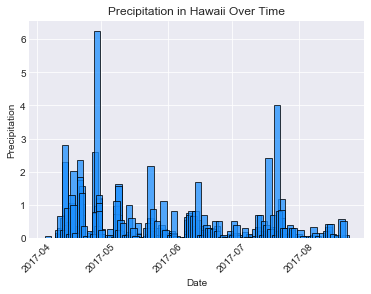

In [12]:
# Plot the precip results using the DataFrame plot method.
plt.bar(precip_df['Date'], precip_df['Precipitation'],
            color='dodgerblue', edgecolor='black',
            alpha=.75, width=3)

# Display x-axis tick labels at 45 degree angle.
plt.xticks(rotation=45)

# Label chart x- and y-axes and give it a title.
plt.title('Precipitation in Hawaii Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation')

# Set chart area to dark grid style.
sns.set_style('darkgrid')

# Save plot to output folder and display
output_path = os.path.join('output', 'precip_barchart.png')
plt.savefig(output_path, dpi=100)
plt.show()

In [13]:
# Use Pandas to print the summary statistics for
# the precipitation data.
precip_df['Precipitation'].describe()

count    733.000000
mean       0.173629
std        0.438130
min        0.000000
25%        0.000000
50%        0.020000
75%        0.140000
max        6.250000
Name: Precipitation, dtype: float64

# Station Analysis

## 1) Asses which station has the highest number of observations.

In [14]:
# Design a query to calculate the total number of stations.
station_count = session.query(Station).count()

In [15]:
# Design a query to find the most active stations.
meas_count_query = session.query(Measurement)
stations_query = session.query(Station)

precip_stations = []
tobs = []
dates = []
station_ids = []
station_names = []

for record in meas_count_query:
    precip_stations.append(record.station_id)
    tobs.append(record.tobs)
    dates.append(record.date)

measurements_df = pd.DataFrame(data={'station_id':precip_stations,
                                          'tobs':tobs,
                                          'date':dates})

for record in stations_query:
    station_ids.append(record.station_id)
    station_names.append(record.name)

stations_df = pd.DataFrame(data={'station_id':station_ids,
                                 'Station Name':station_names})

In [16]:
# List the stations and observation counts in descending order
grouped_measurements = pd.DataFrame(measurements_df.\
                                    groupby('station_id')['station_id'].\
                                    count())
grouped_measurements = grouped_measurements.rename(columns=
                                                   {'station_id':'obs_count'}).\
                                                   reset_index()
grouped_measurements = pd.merge(grouped_measurements,
                                stations_df,
                                on='station_id')\
                                .sort_values('obs_count',ascending=False)
grouped_measurements

,station_id,obs_count,Station Name
5,USC00519281,2772,"WAIHEE 837.5, HI US"
1,USC00513117,2696,"KANEOHE 838.1, HI US"
6,USC00519397,2685,"WAIKIKI 717.2, HI US"
7,USC00519523,2572,"WAIMANALO EXPERIMENTAL FARM, HI US"
2,USC00514830,1937,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
0,USC00511918,1932,"HONOLULU OBSERVATORY 702.2, HI US"
3,USC00517948,683,"PEARL CITY, HI US"
4,USC00518838,342,"UPPER WAHIAWA 874.3, HI US"


Station USC00519281 (Waihee 837.5, HI US) has the highest number of observations.

### 2) Create a histogram of observed temperature frequency at the station with the most observations.

In [17]:
# Design a query to retrieve the last 12 months of
# temperature observation data (tobs). Filter by the
# station with the highest number of observations.

temps_query = session.query(Measurement).filter(Measurement.date>=begin_date,
                                                Measurement.station_id==grouped_measurements.iloc[0]['station_id'])
temps = []
temp_stations = []
for record in temps_query:
    temps.append(record.tobs)
    temp_stations.append(record.station_id)

# Create a dataframe to hold temps and station IDs.
temp_df = pd.DataFrame(data={"station_id":temp_stations,
                                  "Observed Temperature":temps})

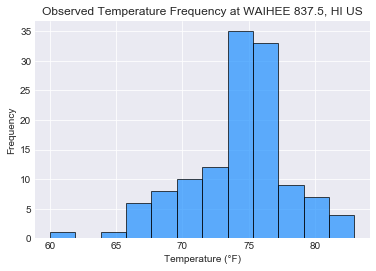

In [18]:
# Plot the results as a histogram with bins=12.
plt.hist(temp_df['Observed Temperature'], bins=12,
         color='dodgerblue',edgecolor='black',
         alpha=.7)

# Set chart title, x-label, and y-label.
plt.title('Observed Temperature Frequency at '
          + grouped_measurements.iloc[0]['Station Name'])
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')

# Save plot to output folder and display
output_path = os.path.join('output', 'temp_histogram.png')
plt.savefig(output_path, dpi=100)
plt.show()

# Temperature Analysis

### 1) Write a Temperature Function

Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.

In [19]:
def calc_temps(start_date, end_date):
    
    # Convert string input into date object.
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Run a query filtering by the start and end date.
    temp_function_query = session.query(Measurement).\
            filter(Measurement.date>=start_date,
                   Measurement.date<=end_date)
        
    # Initiate empty lists to hold records' info
    obs_temps = []
    temp_function_stations = []
    temp_function_date = []
    for record in temp_function_query:
        obs_temps.append(record.tobs)
        # Including station ID and date if I decide to build on this
        # and return more info than just the temperatures.
        temp_function_stations.append(record.station_id)
        temp_function_date.append(record.date)
    
    # Convert lists to pandas dataframe so we can use min, max, mean functions.
    temp_function_df = pd.DataFrame(data={'station_id':temp_function_stations,
                                         'Observed Temperature':obs_temps,
                                         'Date':temp_function_date})
    
    # Return a dictionary containing the min, avg, and max temps for the date range.
    return {'Minimum Temperature': temp_function_df['Observed Temperature'].min(),
            'Average Temperature': temp_function_df['Observed Temperature'].mean(),
            'Maximum Temperature': temp_function_df['Observed Temperature'].max()}

### 2) Use the Temperature Function:

Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

In [20]:
# My trip dates = July 1-11, 2018.
trip_temps = calc_temps('2017-07-01', '2017-07-11')
trip_temps

{'Average Temperature': 77.58181818181818,
 'Maximum Temperature': 82.0,
 'Minimum Temperature': 69.0}

### 3) Make a Bar Chart

Plot the min, avg, and max temperature from your previous query as a bar chart.
- Use the average temperature as the bar height.
- Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

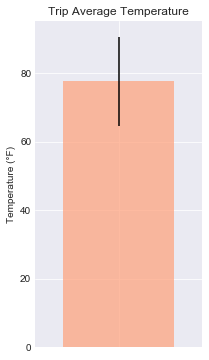

In [21]:
max_temp = trip_temps['Maximum Temperature']
min_temp = trip_temps['Minimum Temperature']
avg_temp = trip_temps['Average Temperature']

# Set the size of the error bar
error_bar = max_temp - min_temp

# Set the figure dimensions (w x h in inches)
plt.figure(figsize=(3, 6))

# Create the bar chart
plt.bar(x='', height=avg_temp, width=1,
        yerr=error_bar, color='lightsalmon',
        alpha=.7)

# Set the x-limits to create padding around the bar.
plt.xlim(-.75,.75)

# Set the title and y-label.
plt.title('Trip Average Temperature')
plt.ylabel('Temperature (°F)')

# Save plot to output folder and display
output_path = os.path.join('output', 'trip_temps_barchart.png')
plt.savefig(output_path, dpi=100, bbox_inches='tight')
plt.show()